# CSE 6367 Programming Assignment 2 (P2)

## Fall 2023

### Task 1 (30 points) 

Implement Hough transform to detect lines in the image. Superimpose detected lines on the original image.

Note: You shouldn't use cv2.HoughCircles() or any other library fuctions to detect the circles.

<img src = Images/lines.jpg>

In [146]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython import display
from scipy import ndimage
import cv2

(303, 300)


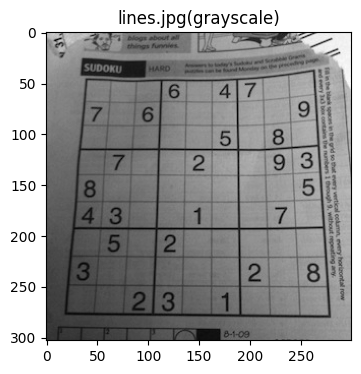

In [147]:
lines_image = cv2.imread('./Images/lines.jpg')
grayscale_lines = cv2.imread('./Images/lines.jpg', 0)
print(grayscale_lines.shape)

plt.figure(figsize=(4,4))
plt.imshow(grayscale_lines, cmap='gray')
plt.title('lines.jpg(grayscale)');

plt.show();

Accumulator Array dimensions: (853, 181)


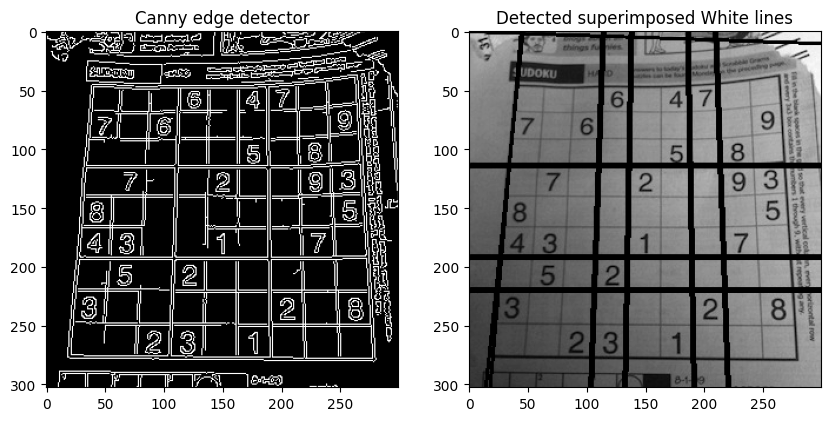

In [148]:
# I've used Canny edge detector for edges and extracting white pixels
edges = cv2.Canny(grayscale_lines, 25, 130, apertureSize=3)

# Theta values in radians from 0 to 180 with 1 degree difference
theta_values = np.deg2rad(np.arange(0, 180, 1))

# To create accumulator array let's define rho(r) not [-inf, inf], it should be finite diagonal image length.
height = grayscale_lines.shape[0]
width = grayscale_lines.shape[1]
diagonal_length = int(np.sqrt(height**2 + width**2)); # This will be -diag_len, +diag_len range of rho(r)

accumulator_array = np.zeros([2*diagonal_length+1, len(theta_values)+1], dtype=np.int32)
print('Accumulator Array dimensions:', accumulator_array.shape)

# Edge pixels in Canny image is gonna be white pixels so easily identified using np.argwhere(edges>0)
edge_pixels = np.argwhere(edges>0)

# Count voting in (rho x theta) array
rho_min = -diagonal_length
rho_max = diagonal_length
for y, x in edge_pixels:
    for theta_idx, theta in enumerate(theta_values):
        rho = int(x * np.cos(theta) + y * np.sin(theta))
        # Handle out-of-range rho values
        if rho < rho_min or rho > rho_max:
            continue
        # Calculate the index in the accumulator array
        rho_index = rho - rho_min
        # Vote for the (rho, theta) pair
        accumulator_array[rho_index, theta_idx] += 1

# Threshold on accumulator_array votes
threshold = 166
peaks = np.argwhere(accumulator_array > threshold)

# np.set_printoptions(threshold=np.inf)
# print(accumulator_array)
# print(np.argmax(accumulator_array)

# Convert peak positions back to (rho, theta) values
rho_values = peaks[:, 0] - diagonal_length
theta_values = theta_values[peaks[:, 1]]

# Superimpose lines on the original grayscale image. zip() fetches (rho, theata) pair at same time
for (rho, theta) in zip(rho_values, theta_values):
    # Convert polar coordinates(rho, theta) to Cartesian coordinates(x, y)plane
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    # Calculate the endpoints of the line: Multiply by a factor to extend the line
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    
    # Draw the line on the original grayscale image
    cv2.line(grayscale_lines, (x1, y1), (x2, y2), (0, 255, 255), 2)

plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Canny edge detector')

plt.subplot(1, 2, 2)
plt.imshow(grayscale_lines, cmap='gray')
plt.title('Detected superimposed White lines')

plt.show()


# # Assuming grayscale_lines is your grayscale image
# canny_image = edges = cv2.Canny(grayscale_lines, 25, 130, apertureSize=3)

# lines = cv2.HoughLinesP(canny_image, rho=1, theta=np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

# # Draw the lines on the image
# for line in lines:
#     x1, y1, x2, y2 = line[0]
#     cv2.line(grayscale_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)


# plt.figure(figsize=(4, 4))
# plt.imshow(canny_image, cmap='gray')
# plt.show()

### Task 2 (30 points) 

Implement Hough transform from scratch to detect circles in the image. Refer to this wiki page for pseudocode(https://en.wikipedia.org/wiki/Circle_Hough_Transform). Superimpose detected circles on the original image.

Note: You shouldn't use cv2.HoughCircles() or any other library fuctions to detect the circles.

<img src = Images/circles.jpg>

##### NOTE(For TA): The below implementation for Task-2 will take upto 3 minutes but the result will be accurate circles, the reason is I'm considering min_circle_radius=10 and max_circle_radius=50 and incrementing it by +1, so that range interval is small and will take time. Also, the performace of system is important as it's using RAM and memory of local machine in Jupyter Notebook.

In [ ]:
def find_circles(input_img, min_r, max_r, threshold_val):
    img_array = np.array(input_img)
    h, w = img_array.shape
    max_r = min(max_r, min(h, w))
    
    sin_vals = np.sin(np.arange(0, 3 * np.pi, 0.01))
    cos_vals = np.cos(np.arange(0, 3 * np.pi, 0.01))
    
    accum = np.zeros((h, w, max_r - min_r + 1))
    
    edge_pixels = np.argwhere(img_array > 0)
  
    for x, y in edge_pixels:
        for r in range(min_r, max_r + 1):
            for angle in range(0, 360):
                a = int(x - r * cos_vals[angle])
                b = int(y - r * sin_vals[angle])
                if 0 <= a < w and 0 <= b < h:
                    accum[b, a, r - min_r] += 1

    circle_centers = np.argwhere(accum >= threshold_val)
    return circle_centers + np.array([0, 0, min_r]), accum

def draw_circles(input_img, circle_centers, radius):
    img_with_circles = np.copy(input_img)
    
    for center in circle_centers:
        x, y, r = center
        cv2.circle(img_with_circles, (x, y), r, (255, 0, 0), 2)
        
    return img_with_circles

input_image = cv2.imread("./Images/circles.jpg")
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
canny_edges = cv2.Canny(gray_image, 100, 200)

min_circle_radius = 10
max_circle_radius = 50
detection_threshold = 200

detected_circle_centers, accumulator = find_circles(canny_edges, min_circle_radius, max_circle_radius, detection_threshold)
result_image = draw_circles(input_image, detected_circle_centers, max_circle_radius)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Canny Image")
plt.imshow(canny_edges, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Hough Transform Circle Image")
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

plt.show()


### Task 3 (40 points)

Implement Harris corner detector from scratch. Mark detected corners on original image. 

Note: You shouldn't use cv2.cornerHarris() or any other library functions to detect the corners.

<img src = Images/corners.jpg>

In [ ]:
image = cv2.imread('./Images/corners.jpg', 0)

k = 0.04 
window_size = 3 
threshold = 0.01

dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

Ixx = dx ** 2
Iyy = dy ** 2
Ixy = dx * dy

Sxx = cv2.boxFilter(Ixx, -1, (window_size, window_size))
Syy = cv2.boxFilter(Iyy, -1, (window_size, window_size))
Sxy = cv2.boxFilter(Ixy, -1, (window_size, window_size))

# Compute corner response function R
det = Sxx * Syy - Sxy ** 2
trace = Sxx + Syy
R = det - k * (trace ** 2)

corners = np.zeros_like(image)
corners[R > threshold * R.max()] = 255

# Mark detected corners on the original image
image_with_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image_with_corners[corners == 255] = [0, 0, 255] 

plt.figure(figsize=(5, 5))
plt.imshow(image_with_corners)
plt.title('Harris Corner Detector')
plt.show()


## Submission Guidelines:

    Submit through Canvas your source code in a single .ipynb file. The name of the .ipynb file should be YourStudentID.ipynb. (For example: 1001234567.ipynb)
    Import all the images from the ./Images directory. Your TA will use the same directory name to grade your submission.
    You don't need to attach the image file with your submission.


## References

Line Detection:
1. https://www.geeksforgeeks.org/line-detection-python-opencv-houghline-method/#
2. https://www.analyticsvidhya.com/blog/2022/06/a-complete-guide-on-hough-transform/#:~:text=Hough%20Transform%20is%20a%20computer,they're%20broken%20or%20obscured.
3. https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html
4. Conversion polar to cartesian: https://blog.cambridgecoaching.com/converting-polar-to-cartesian-equations-in-five-easy-steps

Circle Detection:
1. https://theailearner.com/tag/hough-gradient-method/